In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [13]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Liquid_Samples/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
cp_conc = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer Concentration']))
matrix_conc = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer Concentration']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

In [14]:
names = {'TU11': 'RRe-P3HT at 5 mg/mL',
 'TU19': 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU20': 'PS-H8 at 45 mg/mL',
 'TU24': 'RRe-P3HT at 5 mg/mL + PS-D8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)',
 'TU25': 'PS-D8 at 45 mg/mL'}

In [15]:
slds = {'RRe-P3HT':0.676,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426,
       'Toluene-D8':5.664}


In [16]:
file_info = pd.read_csv('../../data/sans/Liquid_Samples/File_Info.csv')
file_assign = dict(zip(file_info['Filename'], file_info['Sample']))

data_dir = '../../data/sans/Liquid_Samples/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = str(file.split('_')[0][:4])
        usans_data[key] = np.loadtxt(data_dir + file,skiprows=4)
    elif 'sans' in file:
        key = file_assign[file]
        if key in sans_data.keys():
            sans_data[key].append(np.loadtxt((data_dir + file),skiprows=12))
        else:
            sans_data[key] = [np.loadtxt((data_dir + file),skiprows=12)]
            
for key, (data1, data2) in sans_data.items():
    x = np.concatenate((data1[:,0], data2[:,0]))
    y = np.concatenate((data1[:,1], data2[:,1]))
    dx = np.concatenate((data1[:,3], data2[:,3]))
    dy = np.concatenate((data1[:,2], data2[:,2]))
    sans_data[key] = sasmodels.data.Data1D(x, y, dx=dx, dy=dy)
    
for key, data in usans_data.items():
    usans_data[key] = sasmodels.data.Data1D(data[:,0],data[:,1],dy=data[:,2])

In [17]:
for key, data in sans_data.items():
    filename = 'Merged_' + key + '.ABS'
    x = data.x
    y = data.y
    dy = data.dy
    
    comb = np.vstack((x,y,dy)).T
    np.savetxt('../../data/sans/Liquid_Samples/' + filename, comb, header='<X> <Y> <dY>')

In [18]:
usans_data

{'TU11': <sasmodels.data.Data1D at 0x10f4fbee0>,
 'TU19': <sasmodels.data.Data1D at 0x1222760d0>,
 'TU20': <sasmodels.data.Data1D at 0x122276370>}

In [19]:
colors = {
    'TU11':'firebrick',
    'TU19':'mediumblue',
    'TU20':'darkorchid',
    'TU24':'darkcyan',
    'TU25':'black',
}

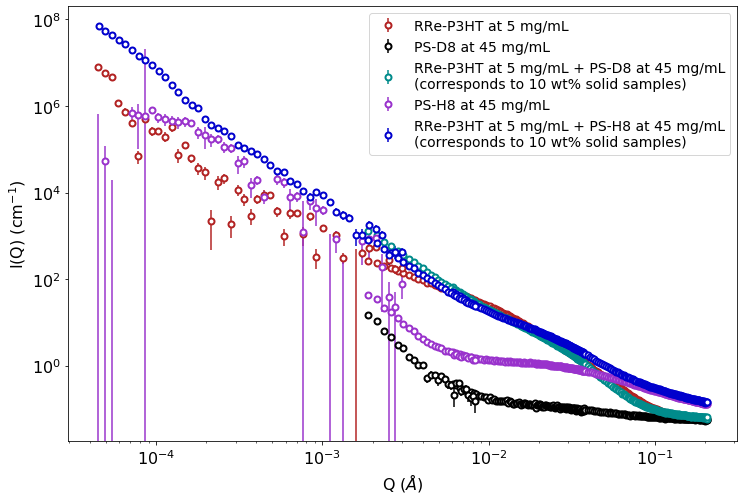

In [20]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24','TU20','TU19']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [220]:
rre = sans_data['TU24']
hps = sans_data['TU25']

In [221]:
sub_x = rre.x
sub_y = rre.y - hps.y
sub = sasmodels.data.Data1D(x=sub_x, y = sub_y)
sans_data['SubHyd'] = sub
colors['SubHyd'] = 'black'
names['SubHyd'] = 'Subtracted RRe-P3HT at 5 mg/mL'

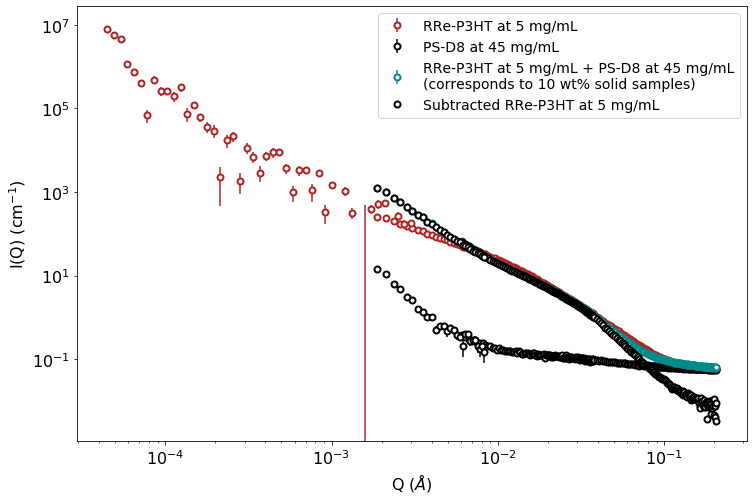

In [222]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU25','TU24','SubHyd']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [190]:
names['TU11'],names['TU20'],names['TU19']

('RRe-P3HT at 5 mg/mL',
 'PS-H8 at 45 mg/mL',
 'RRe-P3HT at 5 mg/mL + PS-H8 at 45 mg/mL\n(corresponds to 10 wt% solid samples)')

In [204]:
rre = sans_data['TU19']
hps = sans_data['TU20']

In [205]:
sub_x = rre.x
sub_y = rre.y - hps.y
sub = sasmodels.data.Data1D(x=sub_x, y = sub_y)
sans_data['SubHyd'] = sub
colors['SubHyd'] = 'black'
names['SubHyd'] = 'Subtracted RRe-P3HT at 5 mg/mL'

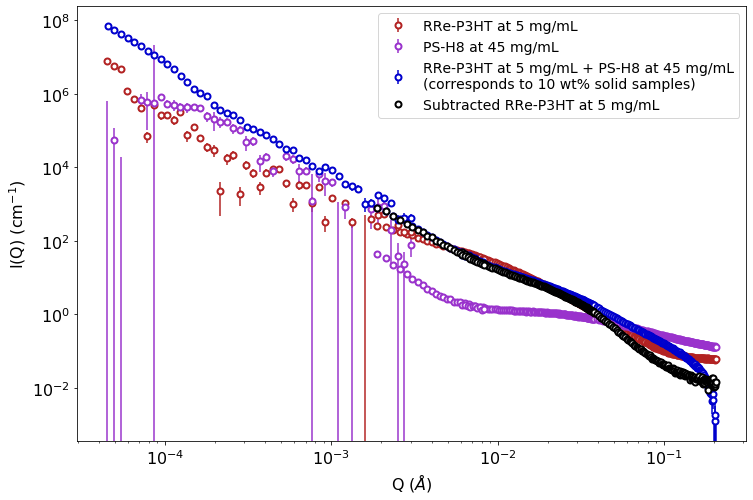

In [206]:
plt.figure(figsize=(12,8))
keys = ['TU11','TU20','TU19','SubHyd']
for key,color in zip(keys,colors):
    sans_load = sans_data[key]
    if key == 'TU19':
        plt.errorbar(sans_load.x,sans_load.y-np.average(sans_load.y[np.where(sans_load.x>0.2)]),yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    else:
        plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],label=names[key],mfc='white',mew=2)
    if key in usans_data.keys():
        usans = usans_data[key]
        plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mfc='white',mew=2)

plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Q $(\AA)$',fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## RRe-P3HT at 5 mg/mL Sample (TU11)

In [26]:
kernel = load_model('flexible_cylinder')
model = Model(model=kernel)
model.parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'length': Parameter(length),
 'length_pd': Parameter(length_pd),
 'length_pd_n': Parameter(length_pd_n),
 'length_pd_nsigma': Parameter(length_pd_nsigma),
 'kuhn_length': Parameter(kuhn_length),
 'kuhn_length_pd': Parameter(kuhn_length_pd),
 'kuhn_length_pd_n': Parameter(kuhn_length_pd_n),
 'kuhn_length_pd_nsigma': Parameter(kuhn_length_pd_nsigma),
 'radius': Parameter(radius),
 'radius_pd': Parameter(radius_pd),
 'radius_pd_n': Parameter(radius_pd_n),
 'radius_pd_nsigma': Parameter(radius_pd_nsigma),
 'sld': Parameter(sld),
 'sld_solvent': Parameter(sld_solvent),
 'up_frac_i': Parameter(up_frac_i),
 'up_frac_f': Parameter(up_frac_f),
 'up_angle': Parameter(up_angle),
 'sld_M0': Parameter(sld_M0),
 'sld_mtheta': Parameter(sld_mtheta),
 'sld_mphi': Parameter(sld_mphi),
 'sld_solvent_M0': Parameter(sld_solvent_M0),
 'sld_solvent_mtheta': Parameter(sld_solvent_mtheta),
 'sld_solvent_mphi': Parameter(sld_solvent_mphi)}

final chisq 616.578(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 9623(61)        9623.2(25)     
                         cylinder radius 82.805(71)      82.8047(28)    
                          cylinder scale 0.0012195(17)   0.001219483(67)
                             kuhn length 19.55(65)       19.547(26)     
                            chain length 9999.268562(27) 9999.2685622(11)
                            chain radius 8.44(11)        8.4418(44)     


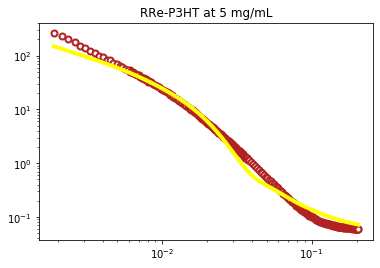

In [187]:
key = 'TU11'
kernel = load_model("cylinder+flexible_cylinder")#+power_law")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]
sans = sans_load
#mask = np.where(sans_load.x>1e-6)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x)),y=np.concatenate((sans_load.y[mask],usans.y)),dy=np.concatenate((sans_load.dy[mask],usans.dy)))
#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(np.average(sans.y[np.where(sans.x>0.2)]), name='background')

A_scale = Parameter(0.0015, name = 'cylinder scale').range(0,0.005/1.11)

A_radius = Parameter(100,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.2, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(10000,limits=[0,inf], name =  'cylinder length').range(0,100000)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_kuhn_length = Parameter(15,limits=[0,inf],name='kuhn length').range(10,500)
B_kuhn_length_pd = Parameter(0, name =  'chain kuhn length pd')
B_kuhn_length_pd_n = Parameter(200, name =  ' chain kuhn length pd n')
B_kuhn_length_pd_nsigma = Parameter(8, name = ' chain kuhn length pd nsigma') 

B_length = Parameter(8500,limits=[0,inf],name='chain length').range(100,10000)
#B_length.limits = [0,inf]
B_length_pd = Parameter(0, name =  'chain length pd')
B_length_pd_n = Parameter(200, name =  ' chain length pd n')
B_length_pd_nsigma = Parameter(8, name = ' chain length pd nsigma') 

B_radius = Parameter(9,limits=[0,inf],name='chain radius').range(3,20)
B_radius_pd = Parameter(0, name = 'chain radius pd')
B_radius_pd_n = Parameter(200, name = 'chain radius pd n')
B_radius_pd_nsigma = Parameter(8, name = 'chain radius pd nsigma')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

B_scale = 0.005/1.11 - A_scale


sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_n = A_radius_pd_n,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_n = A_length_pd_n,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_length = B_length,
    B_length_pd_type='lognormal',
    B_length_pd = B_length_pd,
    B_length_pd_n = B_length_pd_n,
    B_length_pd_nsigma = B_length_pd_nsigma,
    B_kuhn_length = B_kuhn_length,
    B_radius = B_radius,
    B_sld=sld,
    B_sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream', verbose=True,steps=200)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

In [210]:
names['TU25']

'PS-D8 at 45 mg/mL'

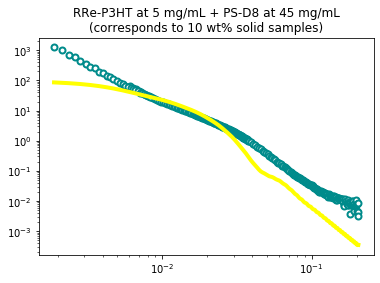

In [226]:
key = 'TU24'
kernel = load_model("cylinder")#+flexible_cylinder")#+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
sans_load2 = sans_data['TU25']
#usans = usans_data[key]

# mask = np.where(sans_load.x>1e-5)
# mask2 = np.where(usans.x>1e-5)
# sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
#sans.mask = np.where((sans.x>0))

#sans= sans_load
sans = sasmodels.data.Data1D(x=sans_load.x,y=sans_load.y-sans_load2.y,dy=sans_load.dy)
# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(0, name='background')

A_scale = Parameter(0.0015, name = 'cylinder scale').range(0,0.005/1.11)

A_radius = Parameter(80,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.2, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(1000,limits=[0,inf], name =  'cylinder length').range(0,100000)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_kuhn_length = Parameter(15,limits=[0,inf],name='kuhn length').range(10,500)
B_kuhn_length_pd = Parameter(0, name =  'chain kuhn length pd')
B_kuhn_length_pd_n = Parameter(200, name =  ' chain kuhn length pd n')
B_kuhn_length_pd_nsigma = Parameter(8, name = ' chain kuhn length pd nsigma') 

B_length = Parameter(8500,limits=[0,inf],name='chain length').range(100,10000)
#B_length.limits = [0,inf]
B_length_pd = Parameter(0, name =  'chain length pd')
B_length_pd_n = Parameter(200, name =  ' chain length pd n')
B_length_pd_nsigma = Parameter(8, name = ' chain length pd nsigma') 

B_radius = Parameter(9,limits=[0,inf],name='chain radius').range(3,20)
B_radius_pd = Parameter(0, name = 'chain radius pd')
B_radius_pd_n = Parameter(200, name = 'chain radius pd n')
B_radius_pd_nsigma = Parameter(8, name = 'chain radius pd nsigma')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

#B_scale=Parameter(0.005,name='chain scale').range(0,0.005)
B_scale = 0.005/1.11 - A_scale
#B_scale=Parameter(0)
#B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

# C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
# C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_D8.value/scale.value)
D_porod_scale = Parameter(porod_scale_D8.value/scale.value)
D_cor_length = Parameter(cor_length_D8.value)
D_porod_exp = Parameter(porod_exp_D8.value)
D_lorentz_exp = Parameter(lorentz_exp_D8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    #scale=scale,
    background=background,
    scale=A_scale,
    radius=A_radius,
    radius_pd_type='lognormal',
    radius_pd = A_radius_pd,
    radius_pd_n = A_radius_pd_n,
    radius_pd_nsigma = A_radius_pd_nsigma,
    length=A_length,
    length_pd_type='lognormal',
    length_pd = A_length_pd,
    length_pd_n = A_length_pd_n,
    length_pd_nsigma = A_length_pd_nsigma,
    sld=sld,
    sld_solvent=sld_solvent,
#     B_scale=B_scale,
#     B_length = B_length,
#     B_length_pd_type='lognormal',
#     B_length_pd = B_length_pd,
#     B_length_pd_n = B_length_pd_n,
#     B_length_pd_nsigma = B_length_pd_nsigma,
#     B_kuhn_length = B_kuhn_length,
#     B_radius = B_radius,
#     B_sld=sld,
#     B_sld_solvent=sld_solvent,
#     C_scale = D_scale,
#     C_lorentz_scale = D_lorentz_scale,
#     C_porod_scale = D_porod_scale,
#     C_cor_length = D_cor_length,
#     C_porod_exp = D_porod_exp,
#     C_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)

#result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream',verbose=True,steps=200)

plt.errorbar(sans.x,sans.y,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

final chisq 1.476(24)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.08238(83)     0.08238(68)    
                              cor_length 24.99(12)       24.993(99)     
                             lorentz_exp 1.9654(97)      1.9654(80)     
                           lorentz scale 1.2693(64)      1.2693(52)     
                               porod_exp 3.716(30)       3.716(25)      
                             porod_scale 3.81(65)e-9     3.81(53)e-9    


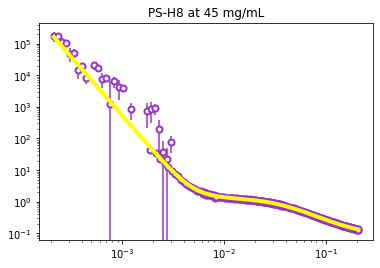

In [173]:
key = 'TU20'
kernel = load_model("correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans_load = usans_data[key]
mask = np.where((usans_load.x>2e-4)&(usans_load.y>1e-1))
usans = sasmodels.data.Data1D(x=usans_load.x[mask],y=usans_load.y[mask],dy=usans_load.dy[mask])

#sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x,usans.x)),y=np.concatenate((sans_load.y,usans.y)),dy=np.concatenate((sans_load.dy,usans.dy)))

# initial parameter values

scale_H8 = Parameter(1,name="scale")
background_H8 = Parameter(0.08339, name = "background").range(0,1)
lorentz_scale_H8 = Parameter(1.2, name = "lorentz scale").range(0,inf)
porod_scale_H8 = Parameter(177.2e-9, name = "porod_scale").range(0,inf)
cor_length_H8 = Parameter(24.016, name = "cor_length").range(0,inf)
porod_exp_H8 = Parameter(3.5, name = "porod_exp").range(0,4)
lorentz_exp_H8 = Parameter(2, name = "lorentz_exp").range(0,4)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_H8,
    background=background_H8,
    lorentz_scale=lorentz_scale_H8,
    porod_scale=porod_scale_H8,
    cor_length=cor_length_H8,
    porod_exp=porod_exp_H8,
    lorentz_exp=lorentz_exp_H8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True, steps=1000)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## PS-D8 at 45 mg/mL Sample (TU25)

final chisq 1.080(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.05300(59)     0.05300(57)    
                              cor_length 29.9(18)        29.9(17)       
                             lorentz_exp 1.732(84)       1.732(81)      
                           lorentz scale 0.0931(55)      0.0931(53)     
                               porod_exp 3.464(67)       3.464(64)      
                             porod_scale 4.6(17)e-9      4.6(16)e-9     


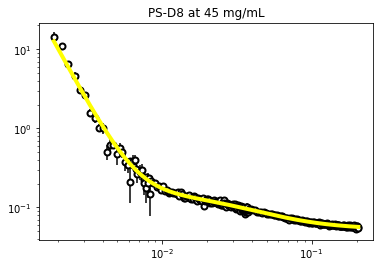

In [174]:
key = 'TU25'
kernel = load_model("correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans_load = usans_data[key]
#mask = np.where((usans_load.x>2e-4)&(usans_load.y>1e-1))
#usans = sasmodels.data.Data1D(x=usans_load.x[mask],y=usans_load.y[mask],dy=usans_load.dy[mask])
mask = np.where(sans_load.x>1e-4)
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x,usans.x)),y=np.concatenate((sans_load.y,usans.y)),dy=np.concatenate((sans_load.dy,usans.dy)))

# initial parameter values

scale_D8 = Parameter(1,name="scale")
background_D8 = Parameter(0.08339, name = "background").range(0,1)
lorentz_scale_D8 = Parameter(1.2, name = "lorentz scale").range(0,inf)
porod_scale_D8 = Parameter(177.2e-9, name = "porod_scale").range(0,inf)
cor_length_D8 = Parameter(24.016, name = "cor_length").range(0,inf)
porod_exp_D8 = Parameter(3.5, name = "porod_exp").range(0,4)
lorentz_exp_D8 = Parameter(2, name = "lorentz_exp").range(0,4)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale_D8,
    background=background_D8,
    lorentz_scale=lorentz_scale_D8,
    porod_scale=porod_scale_D8,
    cor_length=cor_length_D8,
    porod_exp=porod_exp_D8,
    lorentz_exp=lorentz_exp_D8,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)
#result = fit(problem, method='dream', verbose=True, steps=1000)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])
plt.xscale('log')
plt.yscale('log')

## RRe-P3HT at 5 mg/mL and PS-H8 at 45 mg/mL Sample (TU19)

# steps: 200, # draws: 14000
step 1 cost 2248.218(30)
                         cylinder length |.........    5000.09 in (0,100000)
                         cylinder radius ..|.......    79.9997 in (0,300)
                          cylinder scale ..|.......      0.001 in (0,0.0045045)
                             kuhn length |.........    19.9995 in (10,500)
                            chain length .|........    1499.99 in (100,10000)
                            chain radius .|........    5.00001 in (3,20)
                              background |......... 3.91542e-08 in (0,0.1)
step 5 cost 2006.594(30)
step 10 cost 1805.238(30)
step 12 cost 1628.198(30)
step 14 cost 623.336(30)
step 19 cost 488.617(30)
step 24 cost 340.098(30)
step 29 cost 259.204(30)
step 34 cost 196.522(30)
step 39 cost 177.301(30)
step 44 cost 177.301(30)
step 48 cost 177.301(30)
step 53 cost 177.301(30)
step 58 cost 177.301(30)
step 63 cost 177.301(30)
step 68 cost 173.648(30)
step 73 cost 162.178(30)
step 78 cost

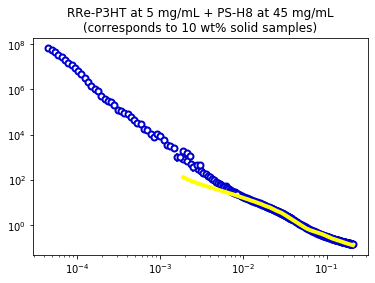

In [178]:
key = 'TU19'
kernel = load_model("cylinder+flexible_cylinder+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
usans = usans_data[key]

# mask = np.where(sans_load.x>1e-5)
# mask2 = np.where(usans.x>1e-5)
# sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
#sans.mask = np.where((sans.x>0))

sans= sans_load
# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(0, name='background').range(0,0.1)

A_scale = Parameter(0.001, name = 'cylinder scale').range(0,0.005/1.11)

A_radius = Parameter(80,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(5000,limits=[0,inf], name =  'cylinder length').range(0,100000)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_kuhn_length = Parameter(20,limits=[0,inf],name='kuhn length').range(10,500)
B_kuhn_length_pd = Parameter(0, name =  'chain kuhn length pd')
B_kuhn_length_pd_n = Parameter(200, name =  ' chain kuhn length pd n')
B_kuhn_length_pd_nsigma = Parameter(8, name = ' chain kuhn length pd nsigma') 

B_length = Parameter(1500,limits=[0,inf],name='chain length').range(100,10000)
#B_length.limits = [0,inf]
B_length_pd = Parameter(0, name =  'chain length pd')
B_length_pd_n = Parameter(200, name =  ' chain length pd n')
B_length_pd_nsigma = Parameter(8, name = ' chain length pd nsigma') 

B_radius = Parameter(5,limits=[0,inf],name='chain radius').range(3,20)
B_radius_pd = Parameter(0, name = 'chain radius pd')
B_radius_pd_n = Parameter(200, name = 'chain radius pd n')
B_radius_pd_nsigma = Parameter(8, name = 'chain radius pd nsigma')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

#B_scale=Parameter(0.005,name='chain scale').range(0,0.005)
B_scale = 0.005/1.11 - A_scale
#B_scale=Parameter(0)
#B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

# C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
# C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_H8.value/scale.value)
D_porod_scale = Parameter(porod_scale_H8.value/scale.value)
D_cor_length = Parameter(cor_length_H8.value)
D_porod_exp = Parameter(porod_exp_H8.value)
D_lorentz_exp = Parameter(lorentz_exp_H8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_n = A_radius_pd_n,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_n = A_length_pd_n,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_length = B_length,
    B_length_pd_type='lognormal',
    B_length_pd = B_length_pd,
    B_length_pd_n = B_length_pd_n,
    B_length_pd_nsigma = B_length_pd_nsigma,
    B_kuhn_length = B_kuhn_length,
    B_radius = B_radius,
    B_sld=sld,
    B_sld_solvent=sld_solvent,
    C_scale = D_scale,
    C_lorentz_scale = D_lorentz_scale,
    C_porod_scale = D_porod_scale,
    C_cor_length = D_cor_length,
    C_porod_exp = D_porod_exp,
    C_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)

#result=fit(problem, method='lm',verbose=True)
result=fit(problem, method='dream',verbose=True,steps=200)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

In [179]:
A_scale.value*1.1/0.005

0.28636002727323373

final chisq 291.111(26)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 10826(37)       10826.0(22)    
                         cylinder radius 54.497(47)      54.4968(28)    
                          cylinder scale 0.0016906(22)   0.00169058(13) 
                             kuhn length 20.4(18)        20.42(11)      
                            chain length 9.0(20)e3       9.04(12)e3     
                            chain radius 4.86(15)        4.8597(87)     


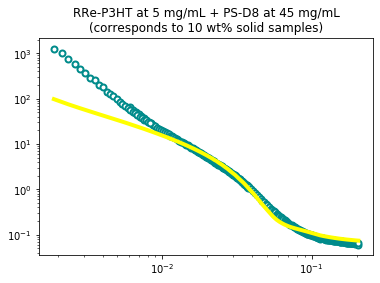

In [186]:
key = 'TU24'
kernel = load_model("cylinder+flexible_cylinder+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans = usans_data[key]

# mask = np.where(sans_load.x>1e-5)
# mask2 = np.where(usans.x>1e-5)
# sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
#sans.mask = np.where((sans.x>0))

sans= sans_load
# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(np.average(sans.y[np.where(sans.x>0.2)]), name='background')

A_scale = Parameter(0.0015, name = 'cylinder scale').range(0,0.005/1.11)

A_radius = Parameter(100,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.2, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(10000,limits=[0,inf], name =  'cylinder length').range(0,100000)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_kuhn_length = Parameter(15,limits=[0,inf],name='kuhn length').range(10,500)
B_kuhn_length_pd = Parameter(0, name =  'chain kuhn length pd')
B_kuhn_length_pd_n = Parameter(200, name =  ' chain kuhn length pd n')
B_kuhn_length_pd_nsigma = Parameter(8, name = ' chain kuhn length pd nsigma') 

B_length = Parameter(8500,limits=[0,inf],name='chain length').range(100,10000)
#B_length.limits = [0,inf]
B_length_pd = Parameter(0, name =  'chain length pd')
B_length_pd_n = Parameter(200, name =  ' chain length pd n')
B_length_pd_nsigma = Parameter(8, name = ' chain length pd nsigma') 

B_radius = Parameter(9,limits=[0,inf],name='chain radius').range(3,20)
B_radius_pd = Parameter(0, name = 'chain radius pd')
B_radius_pd_n = Parameter(200, name = 'chain radius pd n')
B_radius_pd_nsigma = Parameter(8, name = 'chain radius pd nsigma')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

#B_scale=Parameter(0.005,name='chain scale').range(0,0.005)
B_scale = 0.005/1.11 - A_scale
#B_scale=Parameter(0)
#B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

# C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
# C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_D8.value/scale.value)
D_porod_scale = Parameter(porod_scale_D8.value/scale.value)
D_cor_length = Parameter(cor_length_D8.value)
D_porod_exp = Parameter(porod_exp_D8.value)
D_lorentz_exp = Parameter(lorentz_exp_D8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_n = A_radius_pd_n,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_n = A_length_pd_n,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_length = B_length,
    B_length_pd_type='lognormal',
    B_length_pd = B_length_pd,
    B_length_pd_n = B_length_pd_n,
    B_length_pd_nsigma = B_length_pd_nsigma,
    B_kuhn_length = B_kuhn_length,
    B_radius = B_radius,
    B_sld=sld,
    B_sld_solvent=sld_solvent,
    C_scale = D_scale,
    C_lorentz_scale = D_lorentz_scale,
    C_porod_scale = D_porod_scale,
    C_cor_length = D_cor_length,
    C_porod_exp = D_porod_exp,
    C_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)

result=fit(problem, method='lm',verbose=True)
#result=fit(problem, method='dream',verbose=True,steps=200)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

final chisq 20.914(30)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         cylinder length 191.11(35)e3    191106(76)     
                         cylinder radius 28.52(35)       28.519(76)     
                          cylinder scale 0.0010744(60)   0.0010744(13)  
                          free chains rg 57.4(99)        57.4(22)       
                           power law exp 2.573(13)       2.5732(28)     
                         power law scale 93.3(67)e-6     93.3(15)e-6    
                              background 0.05012(26)     0.050116(57)   


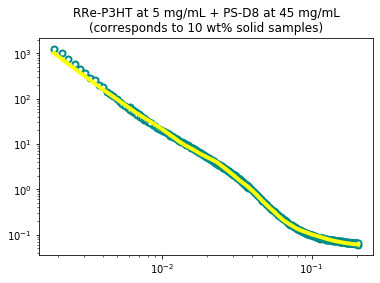

In [193]:
key = 'TU24'
kernel = load_model("cylinder+polymer_excl_volume+power_law+correlation_length")

# loading the data
sans_load = sans_data[key]
sans_load.dx = sans_load.dx-sans_load.dx # removing smearing from sans segment
#usans = usans_data[key]

mask = np.where(sans_load.x>1e-5)
#mask2 = np.where(usans.x>1e-5)
#sans = sasmodels.data.Data1D(x=np.concatenate((sans_load.x[mask],usans.x[mask2])),y=np.concatenate((sans_load.y[mask],usans.y[mask2])),dy=np.concatenate((sans_load.dy[mask],usans.dy[mask2])))
sans = sasmodels.data.Data1D(x=sans_load.x[mask],y=sans_load.y[mask],dy=sans_load.dy[mask])

#sans.mask = np.where((sans.x>0))

# initial parameter values

scale = Parameter(1, name='scale')
background = Parameter(0.06, name='background').range(0,0.1)
#background = Parameter(np.average(sans.x[np.where(sans.x>0.17)]))

A_scale = Parameter(0.01, name = 'cylinder scale').range(0,1*0.005/1.1)

A_radius = Parameter(34,limits=[0,inf], name =  'cylinder radius').range(0,300)
A_radius_pd = Parameter(0.5, name =  'cylinder radius pd')
A_radius_pd_n = Parameter(200, name =  'cylinder radius pd n')
A_radius_pd_nsigma = Parameter(8, name =  ' cylinder radius pd nsigma') 
    
A_length = Parameter(200000,limits=[0,inf], name =  'cylinder length').range(10000,inf)
A_length_pd = Parameter(0, name =  'cylinder length pd')
A_length_pd_n = Parameter(200, name =  ' cylinder length pd n')
A_length_pd_nsigma = Parameter(8, name = ' cylinder length pd nsigma') 

B_rg = Parameter(6,name='free chains rg').range(0,100000)
B_porod_exp = Parameter(3,name='free chains porod exp')

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

B_scale=(1-A_scale)*(sld.value-sld_solvent.value)**2*0.005/1.1

C_scale = Parameter(0.000090,name='power law scale').range(0,inf)
C_power=Parameter(2.5,name='power law exp').range(1,4)

D_scale = Parameter(1)
#D_scale=Parameter(0)
D_lorentz_scale = Parameter(lorentz_scale_D8.value/scale.value)
D_porod_scale = Parameter(porod_scale_D8.value/scale.value)
D_cor_length = Parameter(cor_length_D8.value)
D_porod_exp = Parameter(porod_exp_D8.value)
D_lorentz_exp = Parameter(lorentz_exp_D8.value)

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    A_scale=A_scale,
    A_radius=A_radius,
    A_radius_pd_type='lognormal',
    A_radius_pd = A_radius_pd,
    A_radius_pd_nsigma = A_radius_pd_nsigma,
    A_length=A_length,
    A_length_pd_type='lognormal',
    A_length_pd = A_length_pd,
    A_length_pd_nsigma = A_length_pd_nsigma,
    A_sld=sld,
    A_sld_solvent=sld_solvent,
    B_scale=B_scale,
    B_rg=B_rg,
    B_porod_exp=B_porod_exp,
    C_scale=C_scale,
    C_power=C_power,
    D_scale = D_scale,
    D_lorentz_scale = D_lorentz_scale,
    D_porod_scale = D_porod_scale,
    D_cor_length = D_cor_length,
    D_porod_exp = D_porod_exp,
    D_lorentz_exp = D_lorentz_exp,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

plt.errorbar(sans_load.x,sans_load.y,yerr=sans_load.dy,fmt='o',color=colors[key],mew=2,mfc='white')
#plt.errorbar(usans.x,usans.y,yerr=usans.dy,fmt='o',color=colors[key],mew=2,mfc='white')

sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='yellow')
plt.title(names[key])

plt.xscale('log')
plt.yscale('log')

In [194]:
A_scale.value*1.1/0.005

0.23635844398095124

## Plotting Fit Results

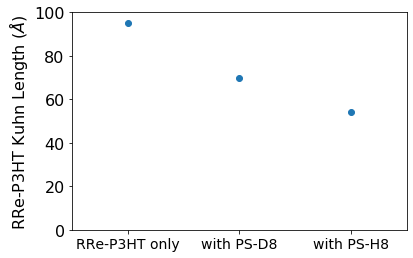

In [160]:
# RRe-P3HT Kuhn Length
x = [1,2,3]
y = [kuhn_length.value, B_kuhn_length_D8.value, B_kuhn_length_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Kuhn Length ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,100)
plt.show()

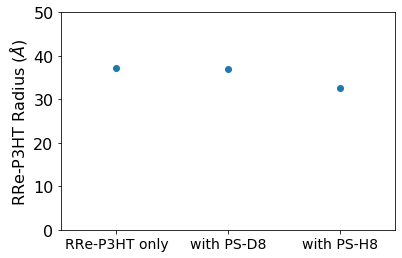

In [161]:
# RRe-P3HT Radius
x = [1,2,3]
y = [radius.value, B_radius_D8.value, B_radius_H8.value]
labels = ['RRe-P3HT only', 'with PS-D8', 'with PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('RRe-P3HT Radius ($\AA$)',fontsize=16)
plt.xlim(0.5,3.5)
plt.ylim(0,50)
plt.show()

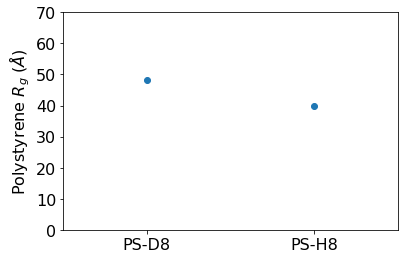

In [162]:
# PS Rg
x = [1,2]
y = [rg_D8.value, rg_H8.value]
labels = ['PS-D8', 'PS-H8']

plt.scatter(x,y)
plt.xticks(x,labels=labels,fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Polystyrene $R_g$ ($\AA$)',fontsize=16)
plt.xlim(0.5,2.5)
plt.ylim(0,70)
plt.show()